In [1]:
NAME = "Michael Cornelisse"
STUDENT_NUMBER = "s1059020"
COLLABORATOR_NAME = "Nienke Helmers"
COLLABORATOR_STUDENT_NUMBER = "s1016904"

In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from graphviz import Source

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost import plot_tree

from toolbox.tools import plot_classification_error, k_fold, plot_tree_graph

In [3]:
PROJECT_ROOT_DIR = "."

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", fig_id)

In [4]:
# Load data
y = pd.read_csv('data/archive/actual.csv', index_col = 'patient')
X_train = pd.read_csv('data/archive/data_set_ALL_AML_train.csv')
X_test = pd.read_csv('data/archive/data_set_ALL_AML_independent.csv')

In [5]:
# Clean all the data
# Drop the call collumns from both data sets
call_cols_train = [col for col in X_train.columns if 'call' in col]
X_train = X_train.drop(call_cols_train, axis = 1)

call_cols_test = [col for col in X_test.columns if 'call' in col]
X_test = X_test.drop(call_cols_test, axis = 1)

# Drop "Gene Description" and "Gene Accession Number"
cols_to_drop = ['Gene Description', 'Gene Accession Number']
X_train = X_train.drop(cols_to_drop, axis = 1)
X_test = X_test.drop(cols_to_drop, axis = 1)

# Transpose both data_sets
X_train = X_train.T
X_test = X_test.T

# now clean the patient_data
y = y.replace({'ALL': 0, 'AML': 1})
y_train = y[y.index <= 38]
y_test = y[y.index > 38]

# Define labels to use in our decission tree later.
patient_labels = ['ALL', 'AML']

In [6]:
# Sort the indices in the data sets
X_train.index = pd.to_numeric(X_train.index) 
X_test.index = pd.to_numeric(X_test.index) 
X_train.sort_index(inplace=True) 
X_test.sort_index(inplace=True)

# Reset the indices
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test= y_test.reset_index(drop=True)

X_train = X_train.replace(np.inf, np.nan)
X_train = X_train.fillna(value = X_train.values.mean())

X_test = X_test.replace(np.inf, np.nan)
X_test = X_test.fillna(value = X_train.values.mean())

#
y = y.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Merge X data sets
X_complete = X_train.append(X_test)
X_complete= X_complete.reset_index(drop=True)
X_complete

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-154,-136,49,180,-257,-273,141,-123,52,878,...,214,540,13,1075,-45,524,249,40,-68,-1
68,-79,-118,-30,68,-110,-264,-28,-61,40,-217,...,409,617,-34,738,11,742,234,72,109,-30
69,-55,-44,12,129,-108,-301,-222,-133,136,320,...,131,318,35,241,-66,320,174,-4,176,40
70,-59,-114,23,146,-171,-227,-73,-126,-6,149,...,214,760,-38,201,-55,348,208,0,74,-12


In [7]:
# PCA
pca = PCA()
pca_data = pca.fit_transform(X_complete)

# Stack explained variance
pca_variance_ratio = pca.explained_variance_ratio_.cumsum()
pca_variance_percentage = pca_variance_ratio*100

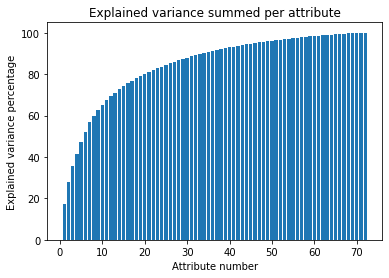

Figure: A plot of the explained variance. The variance is summed for all attributes up to and including
the current attribute number,for examplethe tenth attribute shows the sum of attributes 1 to 10.
There are 33 attributes that together explain 90% of the variance.


In [8]:
# Plot explained variance PCA
plt.bar(range(1,pca_variance_percentage.size+1), pca_variance_percentage)
plt.title("Explained variance summed per attribute")
plt.xlabel("Attribute number")
plt.ylabel("Explained variance percentage")
plt.show()
print('''Figure: A plot of the explained variance. The variance is summed for all attributes up to and including
the current attribute number,for examplethe tenth attribute shows the sum of attributes 1 to 10.''')

#Determine number of attributes needed for an explained variance of 90%
pca_variance_cropped = [i for i in pca_variance_percentage if i <= 90]
no_attributes = len(pca_variance_cropped)
print("There are {} attributes that together explain 90% of the variance." .format(no_attributes))

In [9]:
#Crop pca_data for the useful number of attributes
pca_data = np.delete(pca_data, slice(no_attributes, len(pca_data)) , 1)

#Split data back to original train and test split
X_train_pca = pca_data[:38]
X_test_pca = pca_data[38:]
y = y.ravel()

# Decision tree

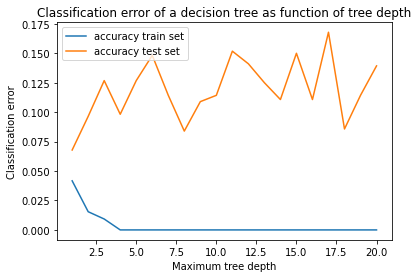

In [27]:
accuracy_mean_train_tree, accuracy_mean_test_tree = k_fold(pca_data, y, 10, 1, 21, 1, 'tree')
plot_classification_error(1, 21, 1, accuracy_mean_train_tree, accuracy_mean_test_tree, 'tree depth')

In [31]:
tree_complete = tree.DecisionTreeClassifier(criterion='gini', max_depth = 4, random_state = 2)
tree_complete = tree_complete.fit(X_train_pca, y_train)
prediction_complete=tree_complete.predict(X_test_pca)
accuracy_complete = metrics.accuracy_score(y_test, prediction_complete)

print("The standard decision tree has an accuracy of {} and an error rate of {}.".format(accuracy_complete, 1-accuracy_complete))

The standard decision tree has an accuracy of 0.8235294117647058 and an error rate of 0.17647058823529416.


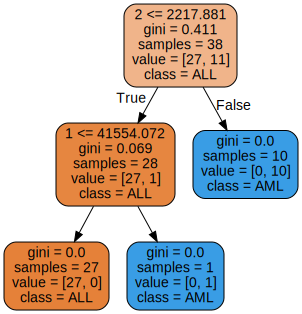

In [29]:
graph = plot_tree_graph(tree_complete, 1, 34)
graph

# Random forest

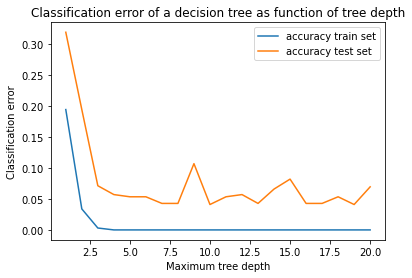

In [13]:
accuracy_mean_train_tree, accuracy_mean_test_tree = k_fold(pca_data, y, 10, 1, 21, 1, 'rf')
plot_classification_error(1, 21, 1, accuracy_mean_train_tree, accuracy_mean_test_tree, 'tree depth')

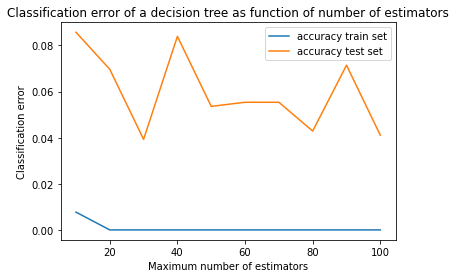

In [32]:
accuracy_mean_train_tree, accuracy_mean_test_tree = k_fold(pca_data, y, 10, 10, 1001, 100, 'rf_estimators')
plot_classification_error(10, 101, 10, accuracy_mean_train_tree, accuracy_mean_test_tree, 'number of estimators')

In [17]:
rf = RandomForestClassifier(n_estimators = 1000, criterion='gini', max_depth = 4)
rf = rf.fit(X_train_pca, y_train)
accuracy = metrics.accuracy_score(y_test, rf.predict(X_test_pca))
print("The Random forest has an accuracy of {} and an error rate of {}.".format(accuracy, 1-accuracy))

<ipython-input-17-11686b54b0b6>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = rf.fit(X_train_pca, y_train)


The Random forrest has an accuracy of 0.8823529411764706 and an error rate of 0.11764705882352944.


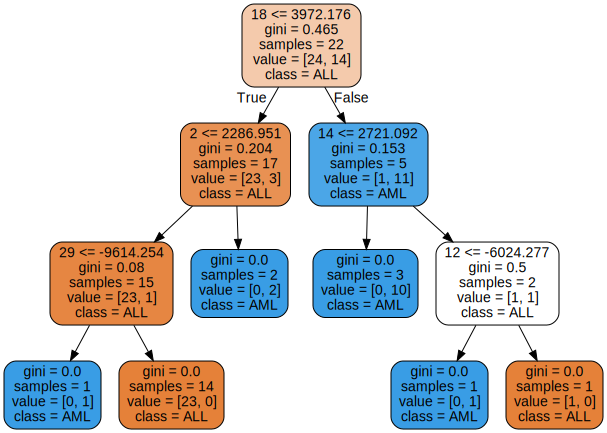

In [18]:
estimator = rf.estimators_[100]
graph_rf = plot_tree_graph(estimator, 1, 34)
graph_rf

# Gradient boosting tree

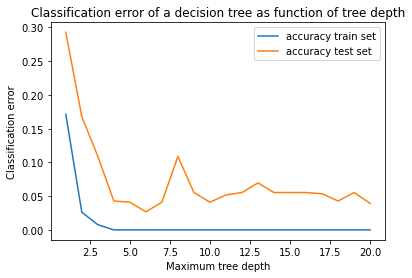

In [19]:
accuracy_mean_train_tree, accuracy_mean_test_tree = k_fold(pca_data, y, 10, 1, 21, 1, 'rf')
plot_classification_error(1, 21, 1, accuracy_mean_train_tree, accuracy_mean_test_tree, 'tree depth')

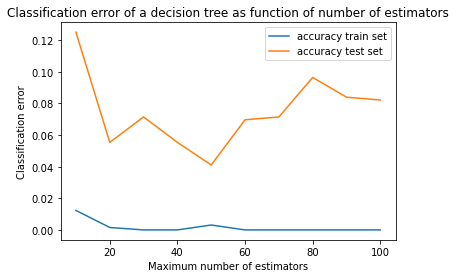

In [22]:
accuracy_mean_train_tree, accuracy_mean_test_tree =  k_fold(pca_data, y, 10, 10, 101, 10, 'rf_estimators')
plot_classification_error(10, 101, 10, accuracy_mean_train_tree, accuracy_mean_test_tree, 'number of estimators')

In [23]:
xb = xgb.XGBClassifier(n_estimators = 50, max_depth = 5, eval_metric='error', use_label_encoder=False)
xb = xb.fit(X_train_pca, y_train)

accuracy = metrics.accuracy_score(y_test, xb.predict(X_test_pca))
print("The XGBoost has an accuracy of {} and an error rate of {}.".format(accuracy, 1-accuracy))

The XGBoost has an accuracy of 0.9411764705882353 and an error rate of 0.05882352941176472.


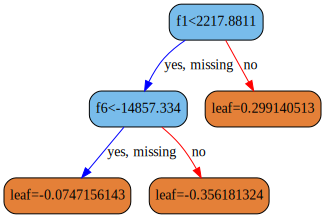

In [24]:
cd = {'shape': 'box',
 'style': 'filled,rounded',
 'fillcolor': '#78bceb'}

lf = {'shape': 'box',
 'style': 'filled, rounded',
 'fillcolor': '#e48038'}

xgb.to_graphviz(xb,condition_node_params = cd, leaf_node_params = lf, num_trees=2, feature_names= "test")